In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import statistics as st

from scipy.stats import shapiro, jarque_bera, norm
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

In [35]:

def get_df(round, day):
    file_name = f"./round-{round}-island-data-bottle/prices_round_{round}_day_{day}.csv"
    return pd.read_csv(file_name, sep=';')

def get_product(df, product):
    return df[df['product'] == product].copy()

def get_first_two_dfs():
    first_df = get_df(1)
    second_df = get_df(2)
    second_df['timestamp'] = second_df['timestamp'] + 1000000
    return pd.concat([first_df, second_df])

def get_obs_df(round, day):
    file_name = f"./round-{round}-island-data-bottle/observations_round_{round}_day_{day}.csv"
    return pd.read_csv(file_name, sep=',')


def


In [36]:
prices_df_list = [get_df(4, day) for day in range(1, 4)]
product_df_list = [get_product(prices_df[day], 'MAGNIFICENT_MACARONS')
              for day in range(0, 3)]
obs_df_list = [get_obs_df(4, day) for day in range(1, 4)]

In [37]:
obs_df_list[0]

,timestamp,bidPrice,askPrice,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex
0,0,627.0,628.5,1.0,9.0,-3.0,200.000000,60.00
1,100,630.0,631.5,1.0,9.0,-3.0,200.098445,60.00
2,200,630.0,631.5,1.0,9.0,-3.0,200.103915,60.00
3,300,632.0,633.5,1.0,9.0,-3.0,200.352462,60.01
4,400,630.5,632.0,1.0,9.0,-3.0,200.201545,60.01
...,...,...,...,...,...,...,...,...
9995,999500,661.0,662.5,1.4,10.5,-4.0,209.926279,64.94
9996,999600,659.5,661.0,1.4,10.5,-4.0,209.565005,64.96
9997,999700,658.5,660.0,1.4,10.5,-4.0,209.504858,64.98
9998,999800,658.0,659.5,1.4,10.5,-4.0,209.482890,65.00


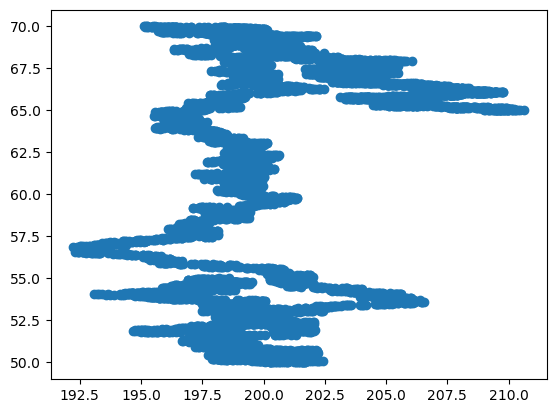

In [39]:
dayIdx = 1

obs_df = obs_df_list[dayIdx]

x = obs_df['sugarPrice']      # or df.iloc[0] for first row
y = obs_df['sunlightIndex']      # or df.iloc[1] for second row

plt.plot(x, y, marker='o')        # line (use plt.scatter for dots only)
plt.show()